# What Was the Effect of The 2017 Boston Marathon on Airbnb Listing Prices in Boston, MA?
### By: Eli Easton


# 1. Introduction

In April 2017, the Boston Marathon drew thousands of participants and media personnel, and tens of thousands of spectators to Boston, Massachusetts (Boston Athletic Association 2017). How, then, did this influx of visitors impact the Boston Airbnb market? Akin to Piga and Melis (2021), my event study ultimately seeks to estimate the causal effect of the 2017 Boston Marathon on local Airbnb listing prices. I hypothesize that the Boston Marathon likely increased local demand for Airbnbs at the neighbourhood level, thus leading to a temporary spike in certain neighbourhood's Airbnb listing prices around the time of the marathon. 

In this project, I assess the validity of my research question and hypothesis. Using the Boston Airbnb Calendar and Listings datasets, alongside a Crime in Boston dataset, which were all sourced from Kaggle, I first determine if there was a spike in Airbnb listing prices in April 2017, the month of the marathon. From this, I assess my proposed research design. My challenge is that Airbnb properties are not randomly treated with ‘Boston Marathon’ or ‘No Boston Marathon.’ Thus, drawing inspiration from Greenstone and Gallagher (2008), who measure the welfare effect of a hazardous waste cleanups by comparing locations that got cleaned to ones that just missed getting cleaned, I aim to determine if neighbourhoods near the Boston Marathon, and neighbourhoods farther away, are valid treatment and control groups respectively (Greenstone and Gallagher 2008, 951). However, comparing neighbourhoods is not comparing ‘apples to apples.’ Thus, this project will also determine relevant control variables that will help make more like comparisons. I ultimately find that my proposed research question and design are valid, there is a spike in listing prices around the time of the marathon that varies at the neighbourhood level. There are also many valid controls which can be exploited to better estimate the causal effect of the 2017 Boston Marathon on local Airbnb prices.



# 2. Data Cleaning & Loading

I begin with the Boston Airbnb Calendar dataset, which contains 1.05 million observations of Airbnb listing-dates in Boston from September 2016 to September 2017. This dataset allows me to observe the change in a property's listing price over time. To obtain more detailed information on Airbnb properties, I then merge it with the Boston Airbnb Listings dataset, which contains data on the characteristics of these 3586 Airbnb properties. Lastly, it is understood that the level of crime in a neighbourhood impacts property value (Cheung and Yiu 2023). Therefore, I also merge the Crimes in Boston dataset to eventually control for neighbourhood level crime.

My main outcome variable is Airbnb listing prices. My main controls are room, property, and bed type, the number of bathrooms, bedrooms, and beds, review score rating, and a ‘superhost’ dummy. In future projects, I will introduce property amenity controls and neighborhood level fixed effects.

The rationale for my controls is as follows. First, room type has a diverse range of values from ‘entire home’ to ‘shared room,’ making it reasonable to assume these categories influence listing price. Similarly, property type varies from a whole house to a dorm, while bed type ranges from a real bed to a couch, making them also likely determinants of price. This same logic also applies to the number of bathrooms, bedrooms, and beds. Akin to Lawani, Reed, Mark, and Zheng (2019) review scores can serve as a proxy for property quality, which influences price. Also, 'superhost' status is another indicator of quality that may impact pricing (Ert and Fleischer 2019, 284-286). Lastly, these variables likely differ systematically across neighbourhoods. Thus, when sorting neighbourhoods into treatment and control groups, it becomes even more crucial to control for these characteristics.




In [148]:
#! pip install -q matplotlib numpy pandas qeds seaborn

In [149]:
#Import libraries
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds
import seaborn as sns

#Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

#Load calendar dataset
calendar = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                       "ECO225Project\\Data\\Boston\\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)

#Clean price column to remove $ and zeroes, convert to float
calendar["price"] = calendar["price"].astype(str).str.replace("$", 
                    "").str.replace(".00", "").str.replace(",", "") \
                    .astype(float)

#Create "year_month" column from the "date" column in "df_calendar" dataset
#Convert "date" column to datetime
#Documentation: 
#https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
calendar["date"] = pd.to_datetime(calendar["date"])

#Create "year_month" column
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\Boston\\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", 
                       "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", 
                       "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", 
                       "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", 
                       "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", 
                       "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", 
                       "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", 
                       "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", 
                       "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", 
                       "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", 
                       "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", 
                       "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", 
                       "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", 
                       "cancellation_policy", "require_guest_profile_picture", 
                       "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", 
                       "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", 
                       "security_deposit", "price", "number_of_reviews"], 
                       inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})

#Room type
for room in ["Entire home/apt", "Private room", "Shared room"]:
    listings[room] = listings["room_type"].map({room: 1}).fillna(0) \
    .astype(int)

#Property type
for property in ["Apartment", "House", "Condominium", "Townhouse", 
                 "Guesthouse", "Loft", "Villa", "Dorm", "Entire Floor", 
                 "Bed & Breakfast", "Boat", "Camper/RV", "Other"]:
    listings[property] = listings["property_type"].map({property: 1})\
    .fillna(0).astype(int)

#Bed type
for bed in ["Real Bed", "Futon", "Pull-out Sofa", "Couch", "Airbed"]:
    listings[bed] = listings["bed_type"].map({bed: 1}).fillna(0).astype(int)

#Neighbourhood
for neighbourhood in ["Allston", "Back Bay", "Bay Village", "Beacon Hill", 
                      "Brighton", "Charlestown", "Chinatown", "Dorchester",
                      "Downtown", "East Boston", "Fenway", "Hyde Park", 
                      "Jamaica Plain", "Longwood Medical Area", 
                      "Leather District", "Mattapan", "Mission Hill", 
                      "North End", "Roslindale", "Roxbury", 
                      "South Boston", "South Boston Waterfront", "South End", 
                      "West End", "West Roxbury"]:
    listings[neighbourhood] = listings["neighbourhood_cleansed"]\
    .map({neighbourhood: 1}).fillna(0).astype(int)

#Merge datasets on id
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"

crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", 
                    "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", 
                    "SHOOTING", "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", 
                    "Long", "STREET"], inplace=True)

#Convert "OCCURRED_ON_DATE" column to datetime
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])

#Create "year_month_crime" column from the "OCCURRED_ON_DATE" column
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")

#Filter dataset to include only data from September 2016 to September 2017
crime = crime[(crime["year_month_crime"] >= "2016-09") & 
              (crime["year_month_crime"] <= "2017-09")]

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

CalLisCrime

,id,date,available,price,year_month,host_is_superhost,host_total_listings_count,street,neighbourhood_cleansed,city,...,South Boston Waterfront,South End,West End,West Roxbury,OFFENSE_CODE_GROUP,OCCURRED_ON_DATE,YEAR,MONTH,Location,year_month_crime
0,3353.0,2017-09-05,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
1,3353.0,2017-09-04,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
2,3353.0,2017-09-03,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
3,3353.0,2017-09-02,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
4,3353.0,2017-09-01,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327772,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Auto Theft Recovery,2016-09-23 19:15:00,2016.0,9.0,"(42.34695268, -71.05112684)",2016-09
327776,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2016-09-12 09:00:00,2016.0,9.0,"(42.36240281, -71.06954652)",2016-09
327777,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2017-01-20 02:00:00,2017.0,1.0,"(42.33001318, -71.09117863)",2017-01
327778,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Drug Violation,2017-01-20 02:00:00,2017.0,1.0,"(42.33001318, -71.09117863)",2017-01


# 3. Summary Statistics Tables

## 3.1. Summary Statistics of Outcome and Key Control Variables

In [150]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and 
#review scores

#Drop duplicate listings 
listings_temp1 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats1 = listings_temp1[["price", "bathrooms", "bedrooms", "beds", 
                                 "review_scores_rating", "Superhost"]] \
                                .describe().round(3)

#Rename rows
summary_stats1.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename columns
summary_stats1.rename(columns={"price": "Price", "bathrooms": "Bathrooms", 
                               "bedrooms": "Bedrooms", "beds": "Beds", 
                               "review_scores_rating": 
                               "Review Scores Rating"}, inplace=True)

#Create title
summary_stats1.style.set_caption("Table 1: Summary Statistics of Price and \
            Key Variables for Airbnb Listings - Boston, MA").format("{:.3f}")


,Price,Bathrooms,Bedrooms,Beds,Review Scores Rating,Superhost
Total Observations,1788.000,3571.000,3575.000,3576.000,2772.000,3585.000
Mean,195.423,1.222,1.256,1.609,91.917,0.114
Standard Deviation,187.577,0.501,0.753,1.012,9.532,0.317
Minimum,20.000,0.000,0.000,0.000,20.000,0.000
25th Percentile,81.000,1.000,1.000,1.000,89.000,0.000
Median (50th Percentile),150.000,1.000,1.000,1.000,94.000,0.000
75th Percentile,250.000,1.000,2.000,2.000,98.250,0.000
Maximum,4000.000,6.000,5.000,16.000,100.000,1.000


Table 1 provides an overview of key characteristics of Airbnb properties in Boston. 

The average number of bathrooms, bedrooms, and beds indicates that most properties are small, making these variables reasonable controls for price trends. However, the presence of large outliers, and a median lower than the mean, indicates a right skew in the distributions which will need to be dealt with in my analysis.

Additionally, Airbnb review scores are high, with an average of 91.9 and a median of 94, suggesting a left skew in the distribution and potential systematic and unobserved differences between guests who do and do not leave reviews. This selection bias will need to be addressed.

Also, superhosts are rare, with only 11.4% of hosts meeting the criteria. Thus, non superhost properties primarily drive price trends, making this variable a reasonable control. 

Importantly, Table 1 may not capture the true listing price variation because it presents only a single observed price per listing rather than the range of prices a property is listed at over time.

In [151]:
#Generate summary statistics of price over time

#Group CalLisCrime by "year_month" and create summary statistics of price
#for each month
summary_stats2 = CalLisCrime.groupby("year_month")["price"].describe() \
                            .round(2)

#Rename columns
summary_stats2.rename(columns={"count": "Count", "mean": "Mean", "std": 
                               "Standard Deviation", "min": "Minimum", 
                               "25%": "25th Percentile", "50%": 
                               "Median (50th Percentile)", "75%": 
                               "75th Percentile", "max": "Maximum"},
                               inplace=True)

#Rename index column
summary_stats2.rename_axis(index="Year-Month", inplace=True)

#Create title and round numbers to 2 decimal places
summary_stats2.style.set_caption("Table 2: Summary Statistics of Airbnb \
                                Listing Price over Time - Boston, MA: September \
                                2016 - September 2017").format("{:.2f}")

,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Year-Month,,,,,,,,
2016-09,24401.00,252.68,193.50,22.00,100.00,209.00,375.00,4000.00
2016-10,46345.00,233.42,185.67,20.00,95.00,185.00,329.00,7163.00
2016-11,58888.00,202.92,167.08,20.00,90.00,160.00,270.00,4000.00
2016-12,60997.00,192.60,162.01,20.00,90.00,155.00,250.00,4000.00
2017-01,63181.00,182.80,155.36,20.00,85.00,150.00,240.00,4000.00
2017-02,56810.00,180.96,160.77,20.00,85.00,150.00,239.00,4000.00
2017-03,55181.00,181.82,168.96,20.00,85.00,149.00,239.00,4000.00
2017-04,51382.00,197.25,191.83,20.00,83.00,150.00,250.00,4000.00
2017-05,53600.00,193.71,184.61,11.00,80.00,150.00,250.00,4000.00


Table 2 shows that listing price undergoes seasonal fluctuations. The data also have high maximum values, suggesting a right skew and outlier observations that need to be addressed. Importantly, there is a large jump in average prices in April 2017, the month of the Boston Marathon, which supports my research hypothesis.

## 3.2. Summary Statistics of Airbnb Properties by Room Type

In [152]:
#Generate summary statistics of listings by room type

#Drop duplicate listings
listings_temp2 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Create table of summary statistics for listings by room type
summary_stats3 = listings_temp2[["Entire home/apt", "Private room", 
                                 "Shared room"]].describe().round(3)

#Rename rows
summary_stats3.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename colmns
summary_stats3.rename(columns={"Entire home/apt": "Entire Home or Apartment", 
                               "Private room": "Private Room",
                               "Shared room": "Shared Room"}, inplace=True)

#Create title
summary_stats3.style.set_caption("Table 3: Summary Statistics of Airbnb \
                                 Properties by Room Type - Boston, MA") \
                                .format("{:.3f}")

,Entire Home or Apartment,Private Room,Shared Room
Total Observations,3585.000,3585.000,3585.000
Mean,0.593,0.384,0.022
Standard Deviation,0.491,0.487,0.148
Minimum,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000
75th Percentile,1.000,1.000,0.000
Maximum,1.000,1.000,1.000


Table 3 presents summary statistics of Boston Airbnbs by room type. 

This table shows that the most common Airbnb room type is an entire home or apartment, while the least common is a shared room. This indicates that listing prices are mostly driven by entire home or apartment listings, thus supporting room type being included as a control.





## 3.3. Summary Statistics of Airbnb Properties by Property Type

In [153]:
#Generate summary stats of property type

#Drop duplicate listings
listings_temp3 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Create table of summary statistics for listings by property type
summary_stats4 = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Townhouse", "Guesthouse", "Loft", 
                                 "Villa", "Dorm", "Entire Floor", 
                                 "Bed & Breakfast", "Boat", "Camper/RV", 
                                 "Other"]].describe().T.round(3)

#Rename columns
summary_stats4.columns = ["Total Observations", "Mean", "Standard Deviation", 
                          "Minimum", "25th Percentile", 
                          "Median (50th Percentile)", "75th Percentile", 
                          "Maximum"]

#Create title
summary_stats4.style.set_caption("Table 4: Summary Statistics of Airbnb \
                                 Properties by Property Type - \
                                 Boston, MA").format("{:.3f}")

,Total Observations,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Apartment,3585.000,0.729,0.445,0.000,0.000,1.000,1.000,1.000
House,3585.000,0.157,0.364,0.000,0.000,0.000,0.000,1.000
Condominium,3585.000,0.064,0.246,0.000,0.000,0.000,0.000,1.000
Townhouse,3585.000,0.015,0.122,0.000,0.000,0.000,0.000,1.000
Guesthouse,3585.000,0.000,0.017,0.000,0.000,0.000,0.000,1.000
Loft,3585.000,0.011,0.104,0.000,0.000,0.000,0.000,1.000
Villa,3585.000,0.002,0.041,0.000,0.000,0.000,0.000,1.000
Dorm,3585.000,0.001,0.024,0.000,0.000,0.000,0.000,1.000
Entire Floor,3585.000,0.001,0.033,0.000,0.000,0.000,0.000,1.000
Bed & Breakfast,3585.000,0.011,0.106,0.000,0.000,0.000,0.000,1.000


Table 4 presents summary statistics of Boston Airbnbs by property type.

This table shows that the most common property type is an apartment while the least common is a camper/RV. This indicates that listing prices are mostly driven by apartment listings, thus supporting property type being included as a control.



## 3.4. Summary Statistics of Airbnb Properties by Neighbourhood

In [154]:
#Generate summary stats of listings by neighbourhood

#Drop duplicate listings
listings_temp4 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Create table of summary statistics for listings by neighbourhood
summary_stats5 = listings_temp4[["Allston", "Back Bay", "Bay Village", 
                                 "Beacon Hill", "Brighton", "Charlestown", 
                                 "Chinatown", "Dorchester", "Downtown", 
                                 "East Boston", "Fenway", "Hyde Park", 
                                 "Jamaica Plain", "Longwood Medical Area", 
                                 "Leather District", "Mattapan", 
                                 "Mission Hill", "North End", "Roslindale", 
                                 "Roxbury", "South Boston", 
                                 "South Boston Waterfront", "South End", 
                                 "West End", 
                                 "West Roxbury"]].describe().T.round(3)

#Rename columns
summary_stats5.columns = ["Total Observations", "Mean", 
                          "Standard Deviation", "Minimum", 
                          "25th Percentile", "Median (50th Percentile)", 
                          "75th Percentile", "Maximum"]

#Create title
summary_stats5.style.set_caption("Table 5: Summary Statistics of Airbnb \
                                 Properties by Neighbourhood - Boston, \
                                 MA").format("{:.3f}")

,Total Observations,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Allston,3585.000,0.073,0.259,0.000,0.000,0.000,0.000,1.000
Back Bay,3585.000,0.084,0.278,0.000,0.000,0.000,0.000,1.000
Bay Village,3585.000,0.007,0.082,0.000,0.000,0.000,0.000,1.000
Beacon Hill,3585.000,0.054,0.226,0.000,0.000,0.000,0.000,1.000
Brighton,3585.000,0.052,0.221,0.000,0.000,0.000,0.000,1.000
Charlestown,3585.000,0.031,0.173,0.000,0.000,0.000,0.000,1.000
Chinatown,3585.000,0.020,0.139,0.000,0.000,0.000,0.000,1.000
Dorchester,3585.000,0.075,0.263,0.000,0.000,0.000,0.000,1.000
Downtown,3585.000,0.048,0.214,0.000,0.000,0.000,0.000,1.000
East Boston,3585.000,0.042,0.200,0.000,0.000,0.000,0.000,1.000


Table 5 presents summary statistics for Airbnb properties by neighbourhood. 

Jamaica Plain had the highest number of Airbnb properties, while the Leather District had the lowest. This suggests that listing prices are more influenced by certain neighbourhoods over others, ultimately reinforcing the need to control for neighbourhood effects.

## 3.5. Statistics of Crime by Year-Month

In [155]:
#Genrate stats of crime incidents

#Group CalLisCrime by "year_month_crime" and describe the "OFFENSE_CODE_GROUP"
#column
summary_stats6 = CalLisCrime.groupby("year_month_crime") \
                            ["OFFENSE_CODE_GROUP"].describe().reset_index()

#Rename columns
summary_stats6.rename(columns={"year_month_crime": "Time", "count": 
                               "Total Number Incidents", "unique": 
                               "Number of Unique Incidents", "top": 
                               "Most Common Incident", "freq": 
                               "Frequency of Most Common Incident"},
                               inplace=True)

#Create title
summary_stats6.style.set_caption("Table 6: Number of Crime Indidents Over \
                                 Time, Boston MA")

,Time,Total Number Incidents,Number of Unique Incidents,Most Common Incident,Frequency of Most Common Incident
0,2016-09,8526,59,Motor Vehicle Accident Response,977
1,2016-10,8586,58,Motor Vehicle Accident Response,1099
2,2016-11,7924,55,Motor Vehicle Accident Response,960
3,2016-12,7951,56,Motor Vehicle Accident Response,1062
4,2017-01,7993,59,Motor Vehicle Accident Response,922
5,2017-02,7408,58,Motor Vehicle Accident Response,950
6,2017-03,8179,59,Motor Vehicle Accident Response,1046
7,2017-04,8072,58,Motor Vehicle Accident Response,986
8,2017-05,8721,59,Motor Vehicle Accident Response,1017
9,2017-06,8990,62,Motor Vehicle Accident Response,1071


Table 6 presents statistics on crime in Boston over my period of interest.

Crime numbers are relatively stable in Boston over time, but likely differ systematically by neighbourhood. In future projects I will use latitude and longitude variables to match crime data to neighbourhoods.  

# 4. Plots, Histograms, and Figures

## 4.1. Bar Graph of Average Airbnb Listing Price Over Time

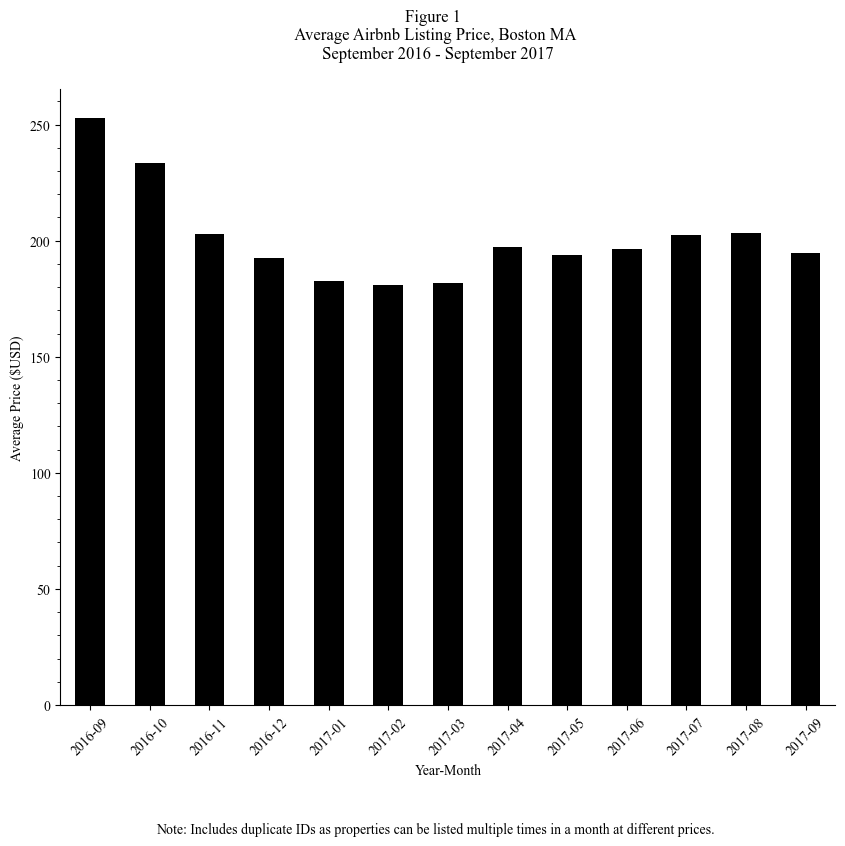

In [156]:
#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = CalLisCrime.groupby("year_month")["price"] \
                            .mean().reset_index()

#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
avg_list_price.plot(x="year_month", y="price", kind="bar", ax=ax, 
                    legend=False, color="black")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create title
fig.suptitle("Figure 1 \n Average Airbnb Listing Price, \
Boston MA \n September 2016 - September 2017")

#Set x label
ax.set_xlabel("Year-Month")

#Rotate x labels
plt.xticks(rotation=45)

#Set y label
ax.set_ylabel("Average Price ($USD)")

#Set y ticks to incriments of 50 for major ticks, 
#and set minor ticks to incriments of 10
ax.set_yticks(np.arange(0, 300, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)

plt.show()

Figure 1 shows the monthly average Airbnb listing price in Boston over my period of interest.

I visualized this because it is necessary to see if the average listing price increased during the month of the Boston Marathon. The jump in average price in April 2017 supports my hypothesis. 

## 4.2. Density Histograms of Airbnb Listing Prices by Month

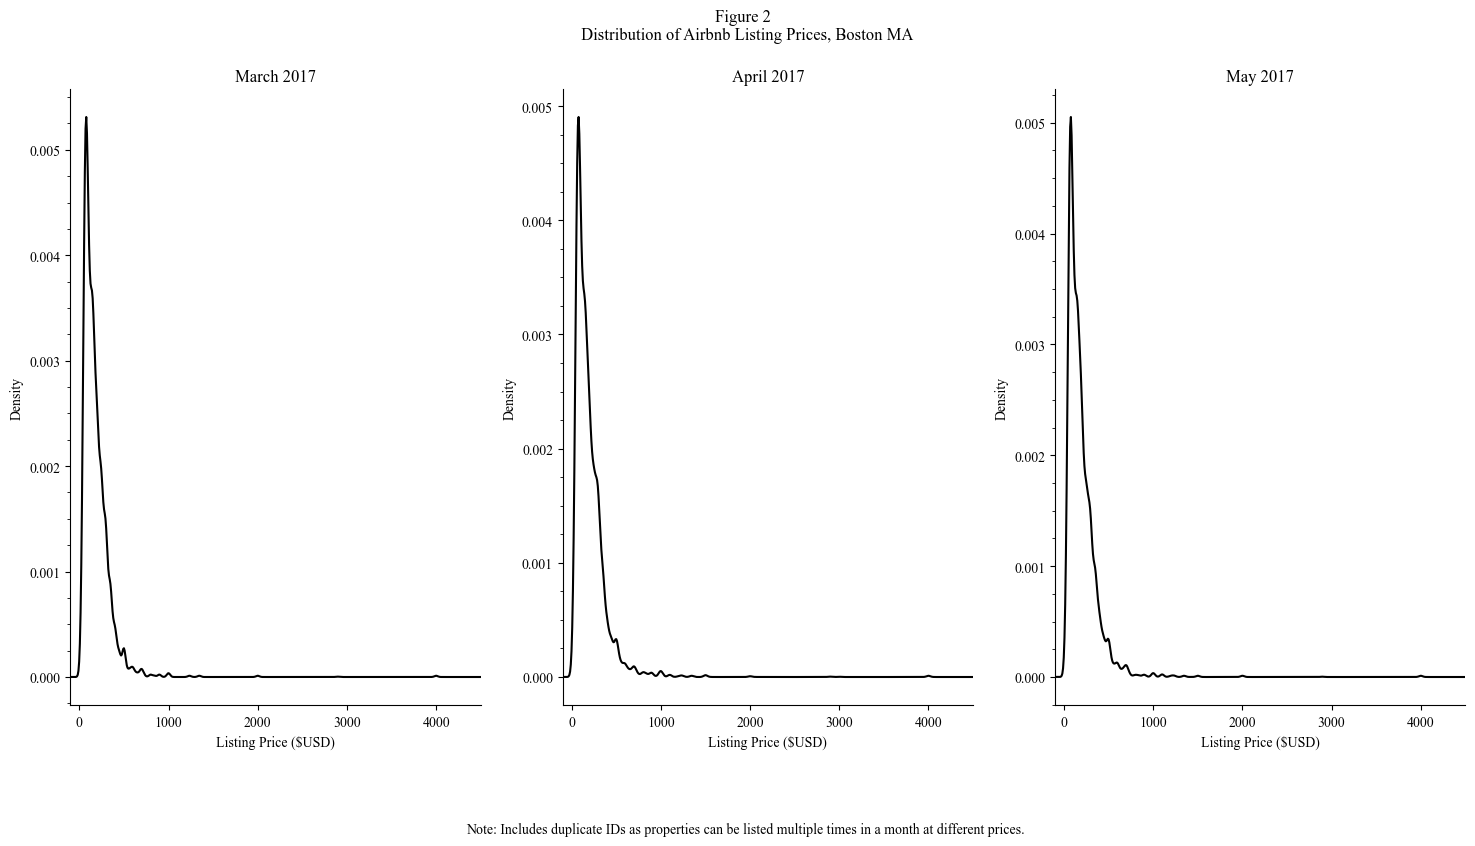

In [157]:
#Create temp datasets for each month
march17 = CalLisCrime[CalLisCrime["year_month"] == "2017-03"]
april17 = CalLisCrime[CalLisCrime["year_month"] == "2017-04"]
may17 = CalLisCrime[CalLisCrime["year_month"] == "2017-05"]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

#Create March histogram at axes[0]
march17.plot.density(y="price", ax=axes[0], legend=False, xlim=(-100, 4500), 
                   color="black") 

#Cleaning
#Remove right and top spines
axes[0].spines["right"].set_visible(False)   
axes[0].spines["top"].set_visible(False)

#Create title
axes[0].set_title("March 2017")

#Create x label
axes[0].set_xlabel("Listing Price ($USD)")

#Set y ticks 
axes[0].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April histogram at axes[1]
april17.plot.density(y="price", ax=axes[1], legend=False, xlim=(-100, 4500), 
                   color = "black") 

#Cleaning
axes[1].spines["right"].set_visible(False)   
axes[1].spines["top"].set_visible(False)

axes[1].set_title("April 2017")

axes[1].set_xlabel("Listing Price ($USD)")

axes[1].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create May histogram at axes[2]
may17.plot.density(y="price", ax=axes[2], legend=False, xlim=(-100, 4500), 
                   color="black") 

#Cleaning
axes[2].spines["right"].set_visible(False)   
axes[2].spines["top"].set_visible(False)

axes[2].set_title("May 2017")

axes[2].set_xlabel("Listing Price ($USD)")

axes[2].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create title
fig.suptitle("Figure 2 \n Distribution of Airbnb Listing Prices, Boston MA")

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)
plt.show()

Figure 2 presents the distribution of Boston Airbnb listing prices for March, April, and May 2017.

I visualized this distribution to check for anomalies in my outcome variable that may distort my future analysis. For instance, there are listing prices around $4000. From this, I may drop the outliers or do a log transformation on the price variable.

I also want to check if there is a significant change in the distribution of prices due to the increased demand brought about by the marathon. However, my figure shows that the distribution is stable, thus necessitating a visualization of the price distributions at the neighbourhood level.  

## 4.3. Box Plots of Airbnb Listing Prices by Neighbourhood and Month

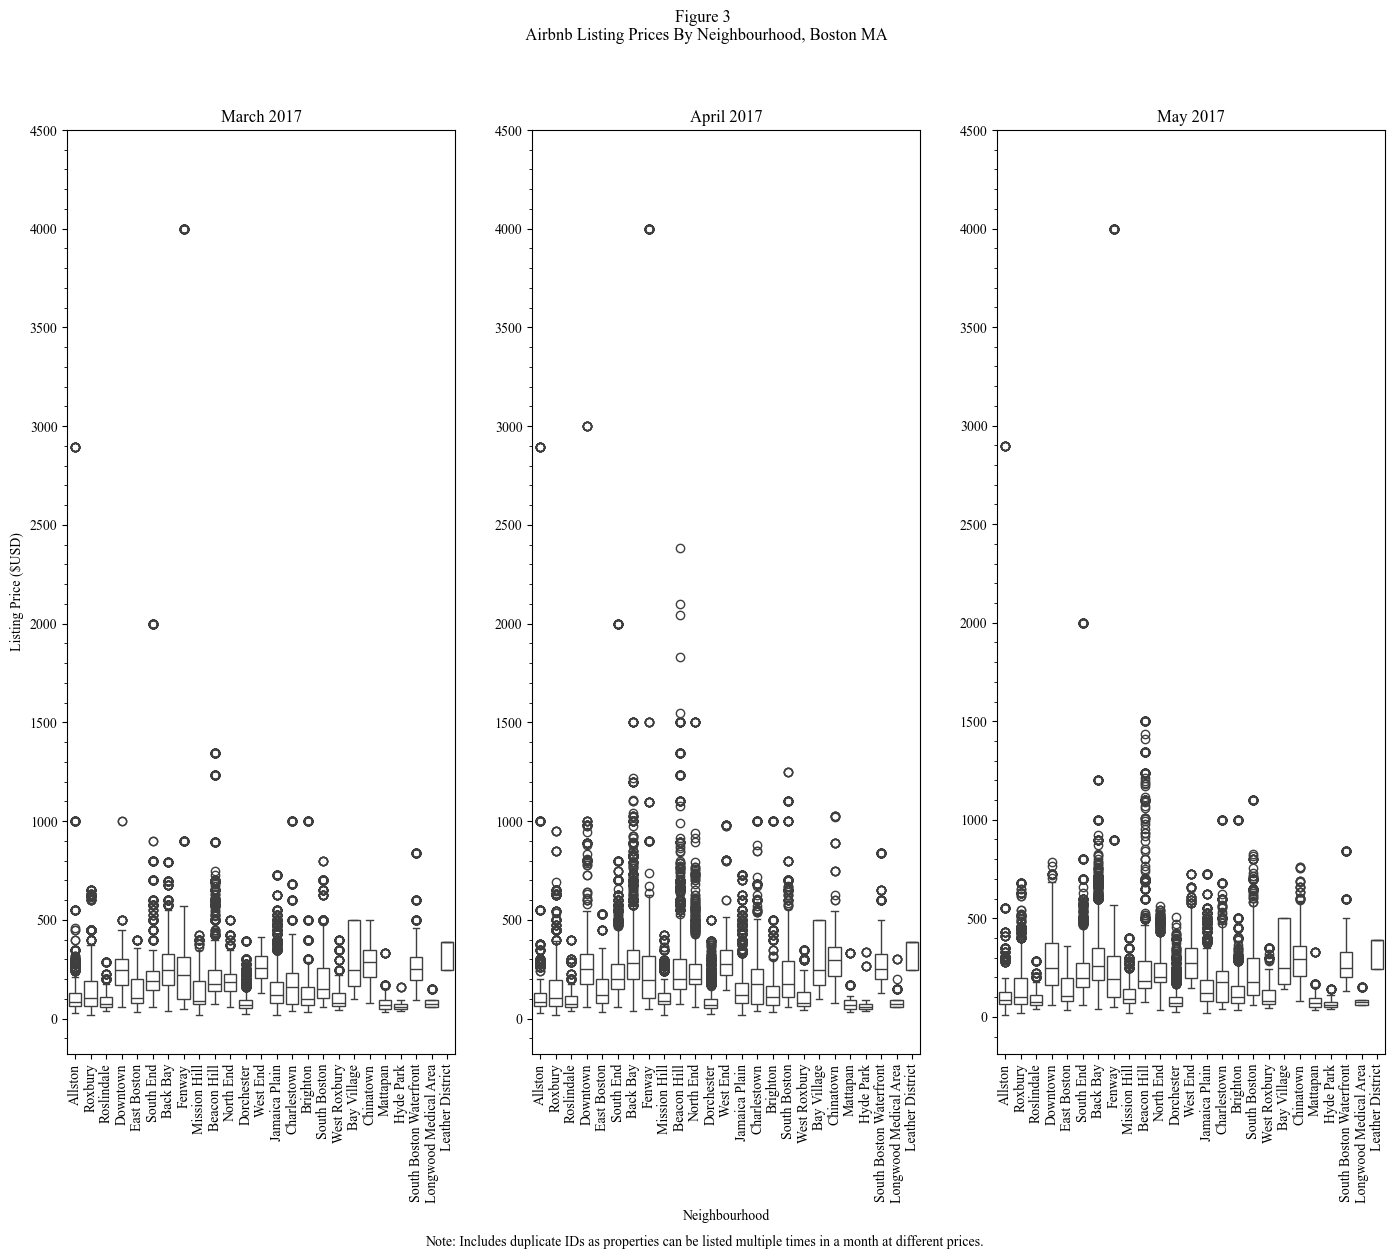

In [158]:
#Idea sourced from: 
#https://www.kaggle.com/code/kostyabahshetsyan/boston-airbnb-visualization

#Create filtered datasets
march17 = CalLisCrime[CalLisCrime["year_month"] == "2017-03"]
april17 = CalLisCrime[CalLisCrime["year_month"] == "2017-04"]
may17 = CalLisCrime[CalLisCrime["year_month"] == "2017-05"]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize = (17, 12))

#Create March 2017 boxplot at axes[0]
sns.boxplot(x ="neighbourhood_cleansed", y="price", data=march17, 
            ax=axes[0], boxprops=dict(facecolor="none"))

#Create title
axes[0].set_title("March 2017")

#Rotate x labels
axes[0].tick_params(axis="x", rotation=90)

#Set y label
axes[0].set_ylabel("Listing Price ($USD)")

#Remove x label
axes[0].set_xlabel("")

#Set y ticks
axes[0].set_yticks(np.arange(0, 5000, 500)) 
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(100)) 

#Create April 2017 boxplot at axes[1]
sns.boxplot(x ="neighbourhood_cleansed", y="price", data=april17, 
            ax=axes[1], boxprops=dict(facecolor="none"))

axes[1].set_title("April 2017")

axes[1].tick_params(axis="x", rotation=90)

axes[1].set_ylabel("")
axes[1].set_xlabel("Neighbourhood")

axes[1].set_yticks(np.arange(0, 5000, 500)) 
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(100)) 

#Create May 2017 boxplot at axes[2]
sns.boxplot(x ="neighbourhood_cleansed", y="price", data=may17, 
            ax=axes[2], boxprops=dict(facecolor="none"))

axes[2].set_title("May 2017")

axes[2].tick_params(axis="x", rotation=90)

axes[2].set_ylabel("")
axes[2].set_xlabel("")

axes[2].set_yticks(np.arange(0, 5000, 500)) 
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(100)) 

fig.suptitle("Figure 3 \n Airbnb Listing Prices By Neighbourhood, Boston MA")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices.", 
ha="center", fontsize=10)

plt.show()


Figure 3 presents box plots of Airbnb listing prices for each neighbourhood in Boston for March, April, and May 2017. 

This figure allows me to assess if prices respond to the April marathon only in certain neighbourhoods. This then helps me determine my treatment and control groups. After assessing a map of Boston neighbourhoods and the marathon route, I find that some neighbourhoods closest to the marathon include Back Bay, Beacon Hill, Fenway, and Allston, while some farthest and less likely to be affected include West Roxbury, and Roslindale (Brady 2017 and City of Boston 2009). 

This figure shows that the listing prices in some potential treatment neighbourhoods increase in April. For instance, Back Bay has a higher mean in April. However, Allston stays relatively consistent. Yet, the potential control neighbourhoods also stay relatively consistent. Therefore, Figure 3 somewhat supports my research design, however more neighbourhood level data needs to be assessed.

## 4.4. Line Plots of Average Listing Price for Potential Treatment and Control Neighbourhoods Over Time

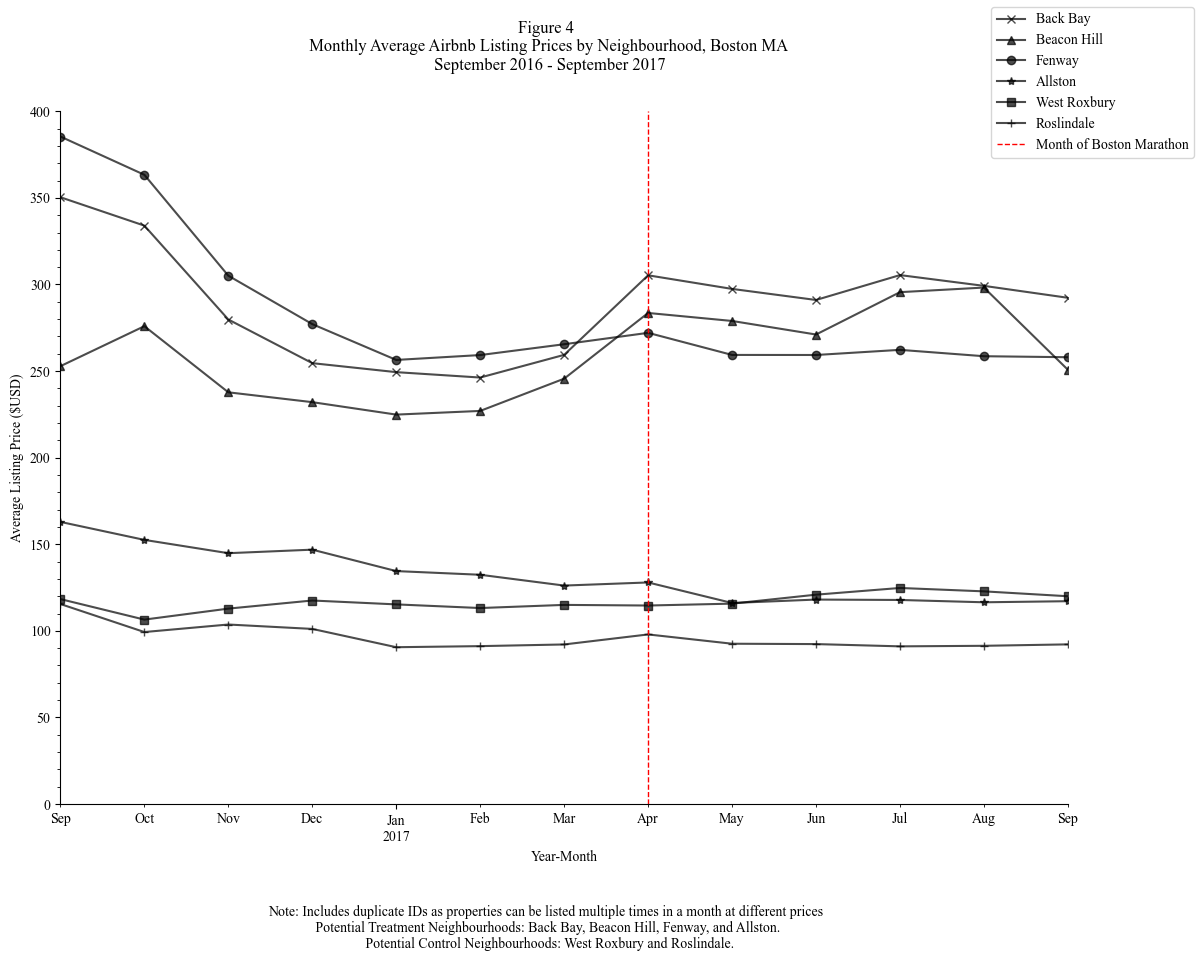

In [159]:
#Group CalLisCrime by "neighbourhood_cleansed" and "year_month" and calculate
#average price
nei_price1 = CalLisCrime.groupby(["neighbourhood_cleansed", 
                                  "year_month"])["price"] \
                        .mean().reset_index()

#Create table of average price by neighbourhood for each month
nei_price1_pivot = nei_price1.pivot(index="year_month", 
                                    columns="neighbourhood_cleansed",
                                    values="price")

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create lines for average price by selected neighbourhood per month
nei_price1_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, 
                                   marker="x", color="black")

nei_price1_pivot["Beacon Hill"].plot(ax=ax, alpha=0.7, legend=False, 
                                      marker="^", color="black")

nei_price1_pivot["Fenway"].plot(ax=ax, alpha=0.7, legend=False, 
                                 marker="o", color="black")

nei_price1_pivot["Allston"].plot(ax=ax, alpha=0.7, legend=False, 
                                  marker="*", color="black")

nei_price1_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, 
                                       marker="s", color="black")

nei_price1_pivot["Roslindale"].plot(ax=ax, alpha=0.7, legend=False, 
                                     marker="+", color="black")

#Create vertical line indicating the month of the Boston Marathon
ax.axvline(x="2017-04", color="red", linestyle="--", linewidth=1, 
           label="Month of Boston Marathon")

#Cleaning
#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Average Listing Price ($USD)")

#Create x label
ax.set_xlabel("Year-Month")

#Create title
fig.suptitle("Figure 4 \n Monthly Average Airbnb Listing Prices by \
Neighbourhood, Boston MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 401, 50)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices \n Potential Treatment \
Neighbourhoods: Back Bay, Beacon Hill, Fenway, and Allston. \n Potential \
Control Neighbourhoods: West Roxbury and Roslindale.", 
ha="center", fontsize=10)

plt.show()


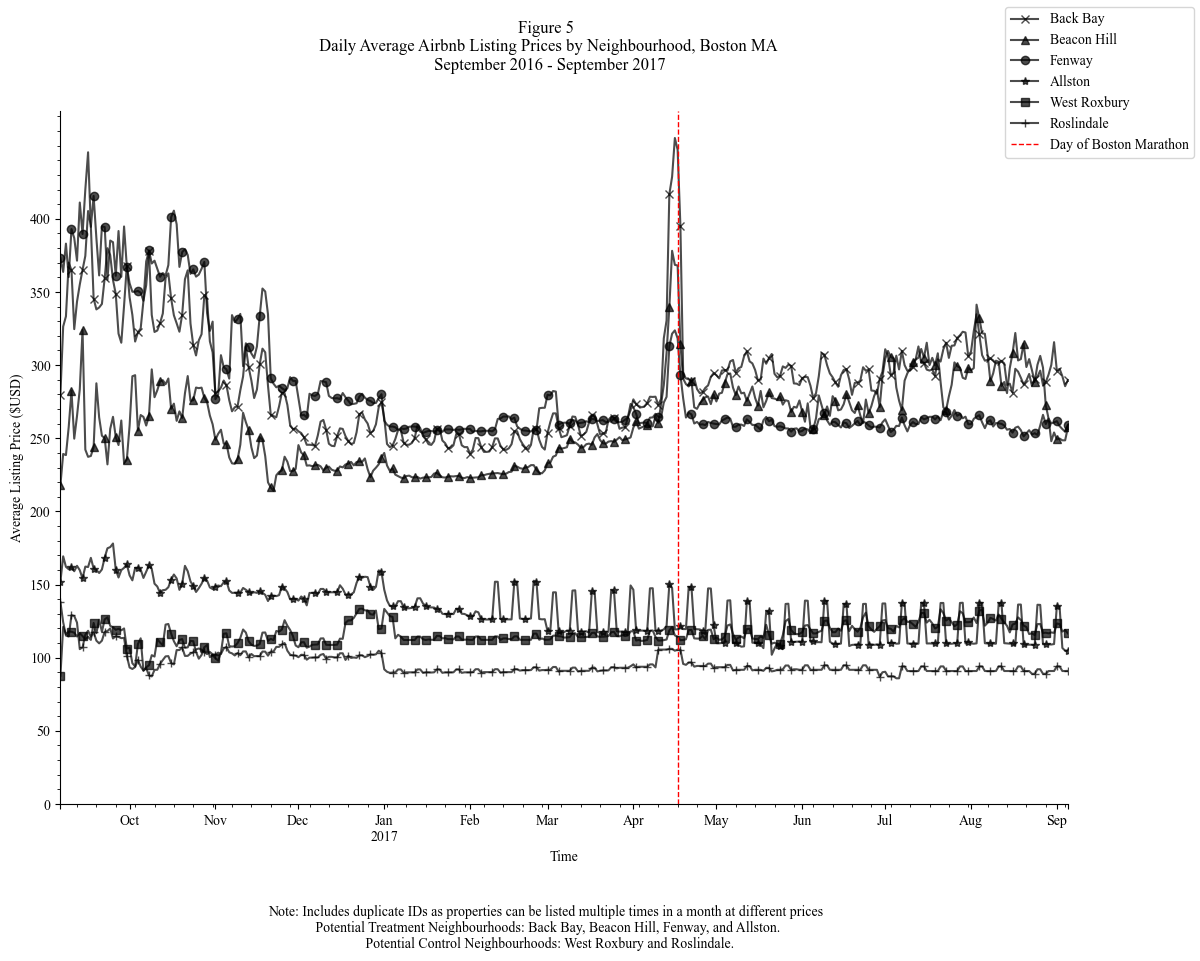

In [160]:
#Group CalLisCrime by "neighbourhood_cleansed" and "date" and calculate
#average price
neigh_price2 = CalLisCrime.groupby(["neighbourhood_cleansed", "date"]) \
                            ["price"].mean().reset_index()

#Create table of average price by neighbourhood for each day
neigh_price2_pivot = neigh_price2.pivot(index="date", 
                                        columns="neighbourhood_cleansed",
                                        values="price")

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create lines for average price by selected neighbourhood per day
neigh_price2_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, 
                                    marker="x", markevery=4, color="black")
neigh_price2_pivot["Beacon Hill"].plot(ax=ax, alpha=0.7, legend=False, 
                                       marker="^", markevery=4, color="black")
neigh_price2_pivot["Fenway"].plot(ax=ax, alpha=0.7, legend=False, 
                                  marker="o", markevery=4, color="black")
neigh_price2_pivot["Allston"].plot(ax=ax, alpha=0.7, legend=False, 
                                   marker="*", markevery=4, color="black")
neigh_price2_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, 
                                    marker="s", markevery=4, color="black")
neigh_price2_pivot["Roslindale"].plot(ax=ax, alpha=0.7, legend=False, 
                                      marker="+", markevery=4, color="black")

#Create vertical line indicating the day of the Boston Marathon
ax.axvline(x="2017-04-17", color="red", linestyle="--", linewidth=1, 
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Average Listing Price ($USD)")

#Create x label
ax.set_xlabel("Time")

#Create title
fig.suptitle("Figure 5 \n Daily Average Airbnb Listing Prices by \
Neighbourhood, Boston MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 401, 50)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices \n Potential Treatment \
Neighbourhoods: Back Bay, Beacon Hill, Fenway, and Allston. \n Potential \
Control Neighbourhoods: West Roxbury and Roslindale.", 
ha="center", fontsize=10)

plt.show()

Figures 4 and 5 present monthly and daily average Airbnb listing prices respectively for the beforementioned potential treatment and control neighbourhoods. 

Figure 5 supports my hypothesis and research design as Back Bay, Beacon Hill, and Fenway’s average listing prices jump around the date of the marathon while West Roxbury’s does not. Roslindale has a relatively smaller increase in price during the marathon and Allston remains as a potential treatment neighbourhood with stable prices during the marathon.

# 5. Conclusion

To conclude, my project shows that in 2017, the average Airbnb listing price in Boston, MA increases during the Boston Marathon. Furthermore, the effect of the marathon appears to be isolated to certain neighbourhoods near the marathon itself. This then supports my research design which assigns neighbourhoods into treatment and control groups. However, simply comparing neighbourhoods is not enough to estimate causality as neighbourhoods differ systematically. Thus, in future projects I will also utilize my controls to make like comparisons and estimate the causal effect of the 2017 Boston Marathon on local Airbnb listing prices.

# Data Sources

Boston Airbnb Open Data: https://www.kaggle.com/datasets/airbnb/boston

Crimes in Boston: https://www.kaggle.com/datasets/ankkur13/boston-crime-data


# Bibliography

Boston Athletic Association Communications Department. 2017. "2017 Boston Marathon Will Mean $192.2 Million For Greater Boston Economy." *Boston Athletic Association*, March 23. https://www.baa.org/2017-boston-marathon-will-mean-1922-million-greater-boston-economy.

Brady, James. 2017. “Boston Marathon 2017: Route information, course map, road closures and more.” *SB Nation*, April 17. https://www.sbnation.com/2017/4/17/15284838/2017-boston-marathon-route-map-traffic.

Cheung, Ka Shing, and Chung Yim Yiu. 2023. “The Paradox of Airbnb, Crime and House Prices: A Reconciliation.” *Tourism Economics: The Business and Finance of Tourism and Recreation* 29 (5): 1412–18. https://doi.org/10.1177/13548166221102808.

City of Boston. 2009. “Neighbourhoods.” Accessed February 4, 2025. https://www.cityofboston.gov/images_documents/Neighborhoods_tcm3-8205.pdf. 

Ert, Eyal, and Aliza Fleischer. 2019. “The Evolution of Trust in Airbnb: A Case of Home Rental.” *Annals of Tourism Research* 75: 279–87. https://doi.org/10.1016/j.annals.2019.01.004. 

Greenstone, Michael, and Justin Gallagher. 2008. “Does Hazardous Waste Matter? Evidence from the Housing Market and the Superfund Program.” *The Quarterly Journal of Economics* CXXIII (3): 951–1004. http://www.jstor.org/stable/25098922. 

Lawani, Abdelaziz, Michael R Reed, Tyler Mark, and Yuqing Zheng. 2019. “Reviews and Price on Online Platforms: Evidence from Sentiment Analysis of Airbnb Reviews in Boston.” *Regional Science and Urban Economics* 75: 22–34. https://doi.org/10.1016/j.regsciurbeco.2018.11.003.

Piga, Claudio, and Giuseppe Melis. 2021. “Identifying and Measuring the Impact of Cultural Events on Hotels’ Performance.” *International Journal of Contemporary Hospitality Management* 33 (4): 1194–1209. https://doi.org/10.1108/IJCHM-07-2020-0749. 
